In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch

In [3]:
from pathlib import Path
from torch.nn.functional import grid_sample
from deepshape.curves import *
from scipy.ndimage import gaussian_filter1d

In [4]:
def resample_collection(collection, k, reparametrizations=None, centering=True):
    x = col_linspace(0, 1, k)
    N = len(collection)
    if reparametrizations is None:
        X = torch.hstack([fi(x) for fi in collection]).transpose(0, 1)
    else:
        X = torch.hstack(
            [fi(ri(x)) for fi, ri in zip(collection, reparametrizations)]
        ).transpose(0, 1)
        
    if centering:
        return X - X.mean(dim=-1, keepdim=True)
    
    return X

def points_to_functional_collection(X):
    return [FuncApprox(X[i]) for i in range(X.shape[0])]

In [5]:
class FuncApprox:
    def __init__(self, data):
        self.data = torch.zeros(1, 1, 1, data.shape[0])
        self.data[0, 0, 0, :] = data.squeeze()
        
    def __call__(self, x):
        grid = torch.zeros(1, 1, x.shape[0], 2)
        grid[0, 0, :, 0] = 2. * x.squeeze() - 1.
        return grid_sample(self.data, grid, padding_mode='border', align_corners=False, mode='bilinear').reshape(-1, 1)
    
    def _create_grid(self, x):
        if self.grid.shape[2] != x.view(-1).shape[0]:
            self.grid = torch.zeros(1, 1, x.shape[0], 2)
        self.grid[0, 0, :, 0] = 2. * x.squeeze() - 1.
        return self.grid
    
    
class FunctionalQmap:
    def __init__(self, f: FuncApprox):
        self.f = f
        
    def __call__(self, x, h=1e-3):
        Df = central_differences(self.f, x, h)
        return torch.sqrt(torch.abs(Df)+1e-8) * self.f(x)
#         return torch.sign(Df) * torch.sqrt(torch.abs(Df)+1e-8)


class SRSF:
    def __init__(self, f: FuncApprox):
        self.f = f
        
    def __call__(self, x, h=1e-3):
        Df = central_differences(self.f, x, h)

        return torch.sign(Df) * torch.sqrt(torch.abs(Df)+1e-8)

def linear_mean(function_collection):
    N = len(function_collection)
    def mean(x):
        return torch.hstack([fi(x) for fi in function_collection]).sum(dim=-1, keepdim=True) / N
    return mean


def torch_mse(x1, x2):
    return ((x1 - x2)**2).sum() / x1.shape[0]

In [6]:
M = np.load("./normal-heatbeat-mean.npy")
M = torch.tensor(M).view(1, -1)
mu = FuncApprox(M.view(-1, 1))

# M = resample_collection(
#     points_to_functional_collection(M),
#     k=1024
# )

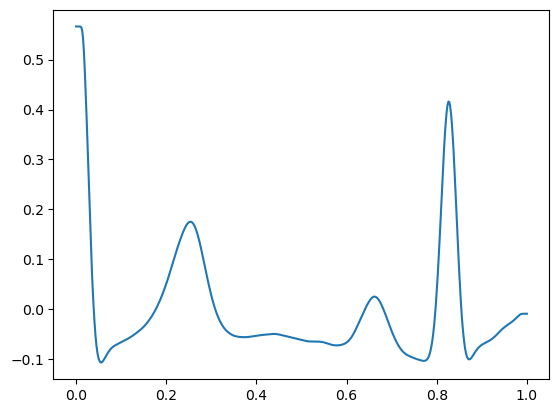

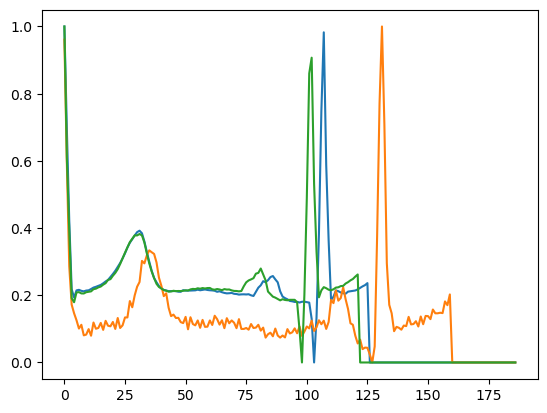

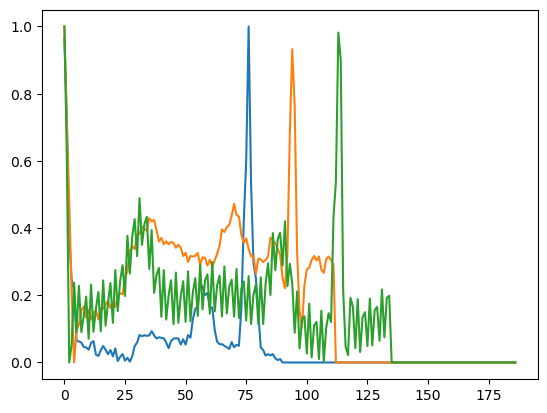

In [7]:
x = col_linspace(0, 1, M.shape[1])
# plt.plot(x, M)
plt.plot(x, mu(x))
plt.show()

datapath = '../data/ptbdb_normal.csv'
dfn = pd.read_csv(datapath + "", header=None)
dfn, labels = dfn.iloc[:, :-1], dfn.iloc[:, -1].astype(int)
plt.plot(dfn.sample(3).transpose())
plt.show()

datapath = '../data/ptbdb_abnormal.csv'
dfabn = pd.read_csv(datapath, header=None)
dfabn, labels = dfabn.iloc[:, :-1], dfabn.iloc[:, -1].astype(int)
plt.plot(dfabn.sample(3).transpose())
plt.show()

In [8]:
def get_ecg_curve(df, idx, sigma=1.5, remove_trailing_zeros=True):
    if type(df) is pd.DataFrame:
        df  = df.to_numpy()
        
    y = torch.tensor(df[idx], dtype=torch.float32)
    if remove_trailing_zeros:
        y = y[torch.nonzero(y, as_tuple=False)]
        
    if sigma > 0.:
        y = gaussian_filter1d(y.squeeze(), sigma=sigma)
        return torch.tensor(y).reshape(-1, 1)
    return y.reshape(-1, 1)

In [9]:
num_funcs = 50
X0 = resample_collection([
    FuncApprox(get_ecg_curve(dfn, i, sigma=0.5, remove_trailing_zeros=True))
    for i in torch.randint(0, high=dfn.shape[0], size=(num_funcs,))
], k=512, centering=False)

X1 = resample_collection([
    FuncApprox(get_ecg_curve(dfabn, i, sigma=0.5, remove_trailing_zeros=True))
    for i in torch.randint(0, high=dfabn.shape[0], size=(num_funcs,))
], k=512, centering=False)

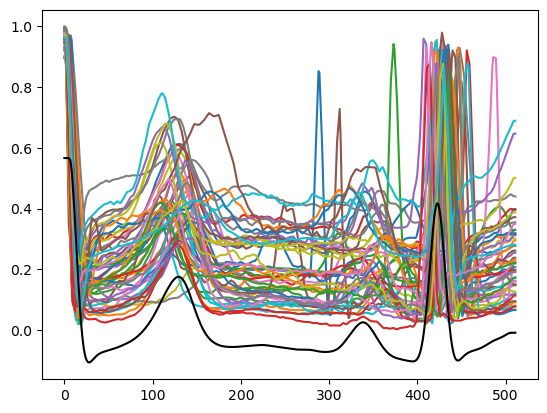

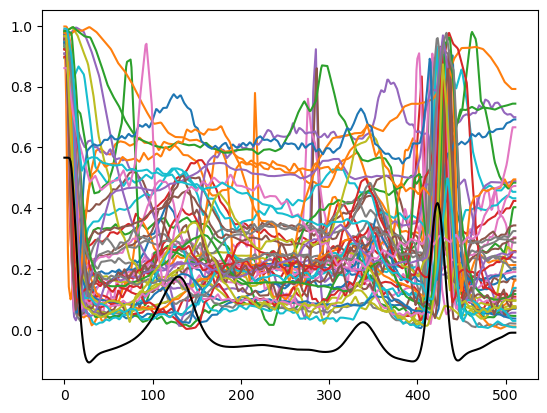

In [10]:
plt.plot(X0.transpose(1, 0))
plt.plot(M.transpose(1, 0), 'k', lw=1.5)
plt.show()

plt.plot(X1.transpose(1, 0))
plt.plot(M.transpose(1, 0), 'k', lw=1.5)
plt.show()

In [11]:
((X0 - M)**2).sum() / X0.shape[0]

tensor(44.9024)

In [12]:
((X1 - M)**2).sum() / X1.shape[0]

tensor(65.9755)

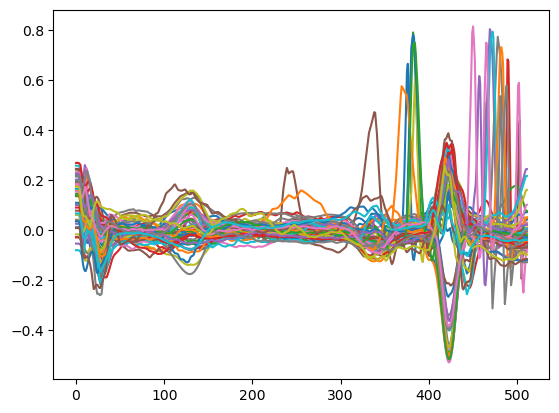

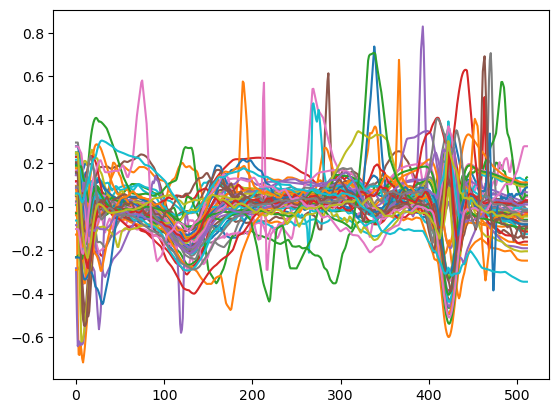

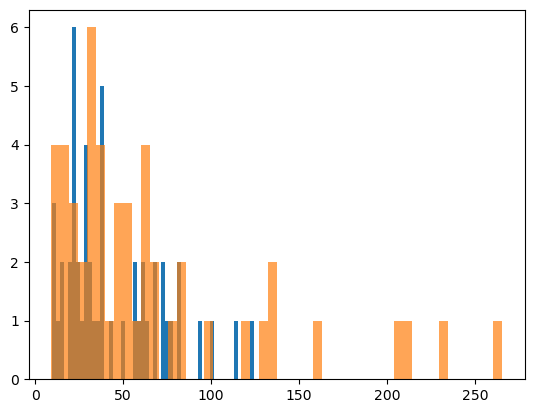

In [30]:
d0 = ((X0 - M)**2).sum(dim=-1)
d1 = ((X1 - M)**2).sum(dim=-1)

plt.plot((X01 - M).transpose(1, 0))
plt.show()

plt.plot((X11 - M).transpose(1, 0))
plt.show()

plt.hist(d0.numpy(), bins=50)
plt.hist(d1.numpy(), bins=50, alpha=0.7)

plt.show()

In [19]:
def get_distances(X0, mu, K=1024, rn_dim=(6, 6), transform=FunctionalQmap):
    # Get input dimensions
    N, k = X0.shape
    
    # Create function collections
    F = points_to_functional_collection(X0)
    Q = [transform(fi) for fi in F]
    
    RN = [
        CurveReparametrizer([
            SineSeries(rn_dim[0]) for _ in range(rn_dim[1])
        ]) for _ in range(N)
    ]
    loss = [
        CurveDistance(mu, r, k=K, h=1e-3) for r in Q
    ]
    dists = np.inf * np.ones(N)
    for i in range(N):
        opt = torch.optim.LBFGS(RN[i].parameters(), max_iter=100, line_search_fn='strong_wolfe')
        dists[i] = reparametrize(RN[i], loss[i], opt, 1, Silent())[-1]
        print(dists[i])
        
        
    for rn in RN:
        for p in rn.parameters():
            p.requires_grad = False
    return RN, dists

0.7686108946800232
0.5889782905578613
0.64732825756073
3.3515067100524902
0.5425580143928528
2.9041991233825684
0.6191948056221008
3.232977867126465
0.9825327396392822
0.7517825961112976
2.527716875076294
0.706590473651886
3.1748900413513184
1.1843481063842773
3.3178765773773193
2.5730228424072266
3.2370195388793945
3.2715821266174316
3.0709683895111084
2.8706421852111816
3.054405450820923
3.31593656539917
0.7122673392295837
0.6766037940979004
1.1192288398742676
0.7321732044219971
0.5897259712219238
2.9110636711120605
0.8709645867347717
0.7400118112564087
0.605681300163269
3.4370036125183105
0.5958369374275208
0.6636682748794556
2.7799699306488037
0.6803678274154663
3.630392074584961
2.5391311645507812
0.9037402868270874
1.2564496994018555
1.1042890548706055
1.0616655349731445
3.1657981872558594
0.7349368333816528
0.5554875135421753
1.5116301774978638
2.975484848022461
0.616077721118927
1.1323683261871338
0.500637948513031


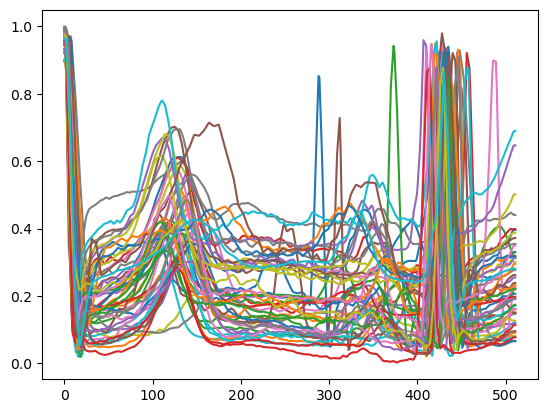

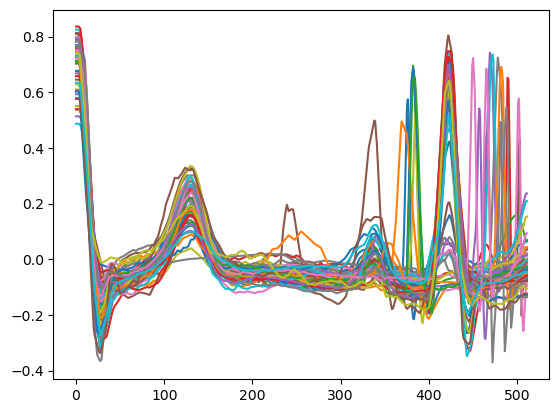

2.046374797821045
1.914562702178955
2.9681529998779297
3.629908561706543
4.3204874992370605
5.802076816558838
8.386628150939941
3.7072033882141113
2.557877540588379
1.6284875869750977
2.689297914505005
8.441781997680664
2.212125301361084
3.0767784118652344
5.607690811157227
2.750122308731079
1.8699133396148682
1.7103474140167236
1.407942295074463
4.550032138824463
1.6231110095977783
1.9492686986923218
4.76127815246582
2.5085432529449463
2.7216885089874268
2.790497064590454
4.5871381759643555
1.9662754535675049
3.0424487590789795
1.5374914407730103
2.9124999046325684
3.500908613204956
3.5508227348327637
3.3588860034942627
1.5994977951049805
1.9391790628433228
1.8871433734893799
1.9574594497680664
2.7948460578918457
2.2175371646881104
4.0490546226501465
4.411706447601318
2.5518503189086914
2.816540002822876
1.5033929347991943
6.4289445877075195
4.530858993530273
2.078259229660034
1.5441604852676392
1.7453011274337769


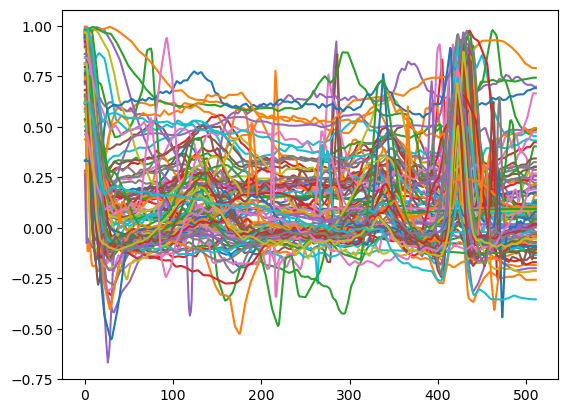

In [28]:
trans = SRSF
RN, d0 = get_distances(X0, trans(FuncApprox(M.transpose(1, 0))), transform=trans,
                      rn_dim=(7, 7))
X01 = resample_collection(points_to_functional_collection(X0), k=X0.shape[1], reparametrizations=RN)
plt.plot(X0.transpose(1, 0))
plt.show()
plt.plot(X01.transpose(1, 0))
plt.show()

RN1, d1 = get_distances(X1, trans(FuncApprox(M.transpose(1, 0))), transform=trans,
                      rn_dim=(3, 3))
X11 = resample_collection(points_to_functional_collection(X1), k=X1.shape[1], reparametrizations=RN1)
plt.plot(X1.transpose(1, 0))
plt.plot(X11.transpose(1, 0))
plt.show()

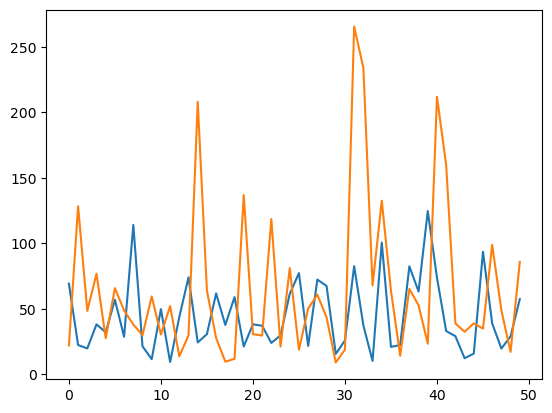

In [31]:
plt.plot(d0)
plt.plot(d1)
plt.show()

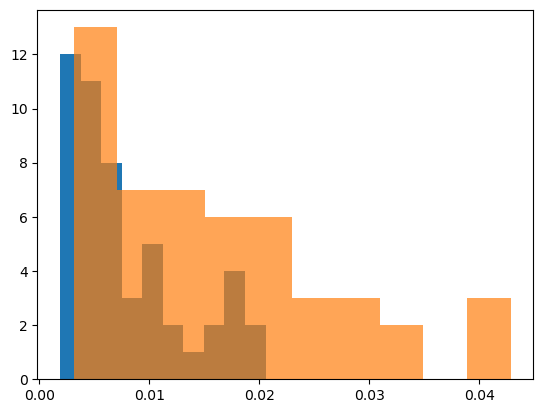

In [35]:
d01 = ((X01 - M)**2).mean(dim=1)
d11 = ((X11 - M)**2).mean(dim=1)

plt.hist(d01.numpy(), bins=10)
plt.hist(d11.numpy(), bins=10, alpha=0.7)

plt.show()

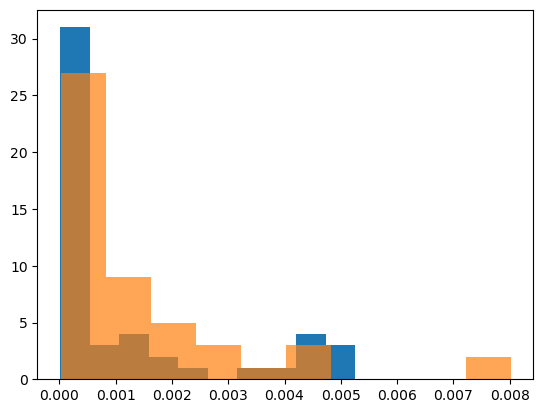

In [39]:
d01 = ((X01 - M)**2).var(dim=1)
d11 = ((X11 - M)**2).var(dim=1)

plt.hist(d01.numpy(), bins=10)
plt.hist(d11.numpy(), bins=10, alpha=0.7)

plt.show()